<a href="https://colab.research.google.com/github/stellagerantoni/LatentCfMultivariate/blob/main/Pendigits_simple_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/stellagerantoni/LatentCfMultivariate

Cloning into 'LatentCfMultivariate'...
remote: Enumerating objects: 263, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 263 (delta 112), reused 36 (delta 36), pack-reused 105
Receiving objects: 100% (263/263), 12.65 MiB | 11.53 MiB/s, done.
Resolving deltas: 100% (152/152), done.


In [2]:
!pip install -q wildboar
!pip install -q scikit-learn
!pip install -q stumpy
!pip install -q fastdtw
!pip install aeon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 11.6 MB/s eta 0:00:00


In [3]:
import logging
import os
import warnings
from argparse import ArgumentParser
from aeon.datasets import load_classification

from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.spatial import distance_matrix
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree, KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from wildboar.datasets import load_dataset
from wildboar.ensemble import ShapeletForestClassifier
from wildboar.explain.counterfactual import counterfactuals
%cd '/content/LatentCfMultivariate'
from _guided import ModifiedLatentCF
from help_functions import *
from keras_models import *

/content/LatentCfMultivariate


In [4]:
os.environ['TF_DETERMINISTIC_OPS'] = '1'
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
RANDOM_STATE = 39

# **ACTUALL CODE**
datasets available : 'Heartbeat', 'SelfRegulationSCP1'

In [5]:
#Getting the dataset

RANDOM_STATE = 39
X,y = load_classification('PenDigits')
X = X.transpose(0,2,1)
print(f'shape of X = {X.shape}')
print(f'shape of y = {y.shape}')
#print(f'data imformation = {data_information}')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
print(f'shape of X train = {X_train.shape}')
print(f'shape of y train = {y_train.shape}')

shape of X = (10992, 8, 2)
shape of y = (10992,)
shape of X train = (8793, 8, 2)
shape of y train = (8793,)


In [6]:
#Upsample the minority class

unique_classes, class_counts = np.unique(y_train, return_counts=True)
print(f'before: {class_counts}')
X_train,y_train = upsample_minority_multivariate(X_train,y_train)
X,y = upsample_minority_multivariate(X, y)
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print(f'after: {class_counts}')

before: [914 914 915 844 915 844 845 914 844 844]
after: [915 915 915 915 915 915 915 915 915 915]


In [7]:
#Processing and Padding all our data
#Padding needed for autoencoder

n_training,n_timesteps, n_features= X_train.shape

X, trained_scaler =  normalize_multivariate(data=X, n_timesteps=n_timesteps, n_features = n_features)
X_train_processed, trained_scaler =  normalize_multivariate(data=X_train, n_timesteps=n_timesteps, n_features = n_features)
X_test_processed, _ =  normalize_multivariate(data=X_test, n_timesteps=n_timesteps, scaler=trained_scaler, n_features = n_features)

X, padding_size = conditional_pad_multivariate(X)
X_train_processed_padded, padding_size = conditional_pad_multivariate(X_train_processed) # add extra padding zeros if n_timesteps cannot be divided by 4, required for 1dCNN autoencoder structure
X_test_processed_padded, _ = conditional_pad_multivariate(X_test_processed)

n_timesteps_padded = X_train_processed_padded.shape[1]
print(f"Data pre-processed, original #timesteps={n_timesteps}, padded #timesteps={n_timesteps_padded}.")

#check the processing (0,1) min should be min 0 and max should be max 1
print(f"\nmin value = {np.min(X_train)}, max value = {np.max(X_train)}")
print(f"min value normalized = {np.min(X_train_processed)}, max value normalized= {np.max(X_train_processed)}")

#check that padding paddes the right dimention
print(f"\nX_train.shape = {X_train.shape}" )
print(f"X_train_processed_padded.shape = {X_train_processed_padded.shape}")


Data pre-processed, original #timesteps=8, padded #timesteps=8.

min value = 0.0, max value = 100.0
min value normalized = 0.0, max value normalized= 1.0

X_train.shape = (9150, 8, 2)
X_train_processed_padded.shape = (9150, 8, 2)


In [8]:
def extract_two_digits(X,y,n_1,n_2, RANDOM_STATE):
  #get the normal and abnormal label
  #abnormal is the target label for the latentCF++ model
  normal_label = n_1
  abnormal_label = n_2

  #Get the indices
  normal_indices = np.where(y == normal_label)[0]
  abnormal_indices = np.where(y == abnormal_label)[0]

  #Use the indices to get the wanted data points
  X_abnormal = X[abnormal_indices]
  y_abnormal = y[abnormal_indices]

  X_normal = X[normal_indices]
  y_normal = y[normal_indices]

  #stack all the data together again
  X = np.concatenate([X_abnormal,X_normal])
  y = np.concatenate([y_abnormal,y_normal])

  #shuffle them
  X, y = shuffle(X, y, random_state=RANDOM_STATE)

  #iterate over the dataset to make the labels 0 for abnormal and 1 for normal

  for i in range(y.shape[0]):
    if y[i] == n_2:
      y[i]=1
    else:
      y [i]=0

  y = y.astype(int)
  print(f'Class 0 represents number {n_1}. [1.,0.]')
  print(f'Class 1 represents number {n_2}. [0.,1.]\n')

  return X,y

In [9]:
#Get only two classes from the dataset (only too needed for counterfactuals)

X, y = extract_two_digits(X,y,'0','8', RANDOM_STATE)
X_train, y_train = extract_two_digits(X_train_processed_padded,y_train,'0','8', RANDOM_STATE)
X_test, y_test = extract_two_digits(X_test_processed_padded,y_test,'0','8', RANDOM_STATE)

Class 0 represents number 0. [1.,0.]
Class 1 represents number 8. [0.,1.]

Class 0 represents number 0. [1.,0.]
Class 1 represents number 8. [0.,1.]

Class 0 represents number 0. [1.,0.]
Class 1 represents number 8. [0.,1.]



In [10]:
#splitting the dataset

from sklearn.model_selection import train_test_split
X_train,X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train)

In [11]:
#Getting the two forms of labels needed
#-the y_classes (1,0,1,0,...)
#-the y (one hot encoded)

print(f'X_train = {X_train.shape}')
print(f'X_validation = {X_validation.shape}')
print(f'X_test = {X_test.shape}')

y_classes = y
y_train_classes = y_train
y_validation_classes = y_validation
y_test_classes = y_test

from tensorflow.keras.utils import to_categorical
y = to_categorical(y, len(np.unique(y)))
y_train = to_categorical(y_train, len(np.unique(y_train)))
y_validation = to_categorical(y_validation, len(np.unique(y_validation)))
y_test = to_categorical(y_test, len(np.unique(y_test)))

print(f'\ny_train_classes = {y_train_classes.shape}, y_validation_classes = {y_validation_classes.shape}, y_test_classes = {y_test_classes.shape}')
print(f'y_train = {y_train.shape}, y_validation = {y_validation.shape}, y_test= {y_test.shape}')

X_train = (1464, 8, 2)
X_validation = (366, 8, 2)
X_test = (440, 8, 2)

y_train_classes = (1464,), y_validation_classes = (366,), y_test_classes = (440,)
y_train = (1464, 2), y_validation = (366, 2), y_test= (440, 2)


In [13]:
def ClassifierLSTM(n_timesteps, n_features, extra_lstm_layer=True, n_output=1):
    # Define the model structure - only LSTM layers
    # https://www.kaggle.com/szaitseff/classification-of-time-series-with-lstm-rnn
    inputs = keras.Input(shape=(n_timesteps, n_features), dtype="float32")
    if extra_lstm_layer:
        x = keras.layers.LSTM(64, activation="tanh", return_sequences=True)(
            inputs
        )  # set return_sequences true to feed next LSTM layer
    else:
        x = keras.layers.LSTM(32, activation="tanh", return_sequences=False)(
            inputs
        )  # set return_sequences false to feed dense layer directly
    x = keras.layers.BatchNormalization()(x)
    # x = keras.layers.LSTM(32, activation='tanh', return_sequences=True)(x)
    # x = keras.layers.BatchNormalization()(x)
    if extra_lstm_layer:
        x = keras.layers.LSTM(16, activation="tanh", return_sequences=False)(x)
        x = keras.layers.BatchNormalization()(x)

    if n_output >= 2:
        outputs = keras.layers.Dense(n_output, activation="softmax")(x)
    else:
        outputs = keras.layers.Dense(1, activation="sigmoid")(x)

    classifier2 = keras.Model(inputs, outputs)

    return classifier2

In [14]:


# ## LatentCF++ models
# reset seeds for numpy, tensorflow, python random package and python environment seed
reset_seeds()
###############################################
# ### LSTM classifier

classifier = ClassifierLSTM(
    n_timesteps_padded, n_features, n_output=2
)

optimizer = keras.optimizers.Adam(lr=0.001)
classifier.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
)

# Define the early stopping criteria
early_stopping_accuracy = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=15, restore_best_weights=True
)
# Train the model
reset_seeds()
print("Training log for LSTM-FCN classifier:")
classifier_history = classifier.fit(
    X_train,
    y_train,
    epochs=150,
    batch_size=12,
    shuffle=True,
    verbose=True,
    validation_data=(X_validation, y_validation),
    callbacks=[early_stopping_accuracy],
)

y_pred = classifier.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
acc = balanced_accuracy_score(y_true=y_test_classes, y_pred=y_pred_classes)
print(f"LSTM-FCN classifier trained, with validation accuracy {acc}.")

confusion_matrix_df = pd.DataFrame(
    confusion_matrix(y_true=y_test_classes, y_pred=y_pred_classes, labels=[1, 0]),
    index=["True:1", "True:0"],
    columns=["Pred:1", "Pred:0"],
)
print(confusion_matrix_df)


Training log for LSTM-FCN classifier:
Epoch 1/150
122/122 [==============================] - 8s 27ms/step - loss: 0.2545 - accuracy: 0.9208 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 2/150
122/122 [==============================] - 1s 11ms/step - loss: 0.0781 - accuracy: 0.9822 - val_loss: 0.8322 - val_accuracy: 0.5000
Epoch 3/150
122/122 [==============================] - 1s 11ms/step - loss: 0.0494 - accuracy: 0.9904 - val_loss: 1.6052 - val_accuracy: 0.5000
Epoch 4/150
122/122 [==============================] - 1s 11ms/step - loss: 0.0321 - accuracy: 0.9945 - val_loss: 0.8264 - val_accuracy: 0.5000
Epoch 5/150
122/122 [==============================] - 1s 11ms/step - loss: 0.0417 - accuracy: 0.9911 - val_loss: 0.0557 - val_accuracy: 0.9891
Epoch 6/150
122/122 [==============================] - 1s 11ms/step - loss: 0.0184 - accuracy: 0.9973 - val_loss: 0.1383 - val_accuracy: 0.9863
Epoch 7/150
122/122 [==============================] - 1s 11ms/step - loss: 0.0244 - accuracy: 0.9

In [15]:
def AutoencoderLSTM(n_timesteps, n_features):
    # Define encoder and decoder structure
    # structure from medium post: https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352
    def EncoderLSTM(input):
        # x = keras.layers.LSTM(64, activation='relu', return_sequences=True)(input)
        x = keras.layers.LSTM(64, activation="tanh", return_sequences=True)(input)
        # encoded = keras.layers.LSTM(32, activation='relu', return_sequences=False)(x)
        encoded = keras.layers.LSTM(32, activation="tanh", return_sequences=False)(x)
        return encoded

    def DecoderLSTM(encoded):
        x = keras.layers.RepeatVector(n_timesteps)(encoded)
        # x = keras.layers.LSTM(32, activation='relu', return_sequences=True)(x)
        x = keras.layers.LSTM(32, activation="tanh", return_sequences=True)(x)
        # x = keras.layers.LSTM(64, activation='relu', return_sequences=True)(x)
        x = keras.layers.LSTM(64, activation="tanh", return_sequences=True)(x)
        decoded = keras.layers.TimeDistributed(
            keras.layers.Dense(n_features, activation="sigmoid")
        )(x)
        return decoded

    # Define the AE model
    orig_input2 = keras.Input(shape=(n_timesteps, n_features))

    autoencoder2 = keras.Model(
        inputs=orig_input2, outputs=DecoderLSTM(EncoderLSTM(orig_input2))
    )

    return autoencoder2

In [16]:
reset_seeds()

# ### LSTM autoencoder
autoencoder = AutoencoderLSTM( n_timesteps_padded,n_features)
optimizer = keras.optimizers.Adam(lr=0.0005)
autoencoder.compile(optimizer=optimizer, loss="mse")

# Define the early stopping criteria
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, restore_best_weights=True)
# Train the model
reset_seeds()
print("Training log for 1dCNN autoencoder:")
autoencoder_history = autoencoder.fit(
    X_train,
    X_train,
    epochs=50,
    batch_size=12,
    shuffle=True,
    verbose=2,
    validation_data=(X_validation, X_validation),
    callbacks=[early_stopping])

ae_val_loss = np.min(autoencoder_history.history['val_loss'])
print(f"1dCNN autoencoder trained, with validation loss: {ae_val_loss}.")


Training log for 1dCNN autoencoder:
Epoch 1/50
122/122 - 12s - loss: 0.0997 - val_loss: 0.0745 - 12s/epoch - 96ms/step
Epoch 2/50
122/122 - 2s - loss: 0.0627 - val_loss: 0.0541 - 2s/epoch - 16ms/step
Epoch 3/50
122/122 - 3s - loss: 0.0427 - val_loss: 0.0345 - 3s/epoch - 21ms/step
Epoch 4/50
122/122 - 2s - loss: 0.0307 - val_loss: 0.0281 - 2s/epoch - 16ms/step
Epoch 5/50
122/122 - 2s - loss: 0.0269 - val_loss: 0.0243 - 2s/epoch - 15ms/step
Epoch 6/50
122/122 - 2s - loss: 0.0236 - val_loss: 0.0224 - 2s/epoch - 16ms/step
Epoch 7/50
122/122 - 2s - loss: 0.0217 - val_loss: 0.0207 - 2s/epoch - 15ms/step
Epoch 8/50
122/122 - 2s - loss: 0.0196 - val_loss: 0.0200 - 2s/epoch - 15ms/step
Epoch 9/50
122/122 - 2s - loss: 0.0181 - val_loss: 0.0188 - 2s/epoch - 19ms/step
Epoch 10/50
122/122 - 2s - loss: 0.0163 - val_loss: 0.0172 - 2s/epoch - 19ms/step
Epoch 11/50
122/122 - 2s - loss: 0.0149 - val_loss: 0.0154 - 2s/epoch - 14ms/step
Epoch 12/50
122/122 - 2s - loss: 0.0137 - val_loss: 0.0156 - 2s/epoch

1/1 [==============================] - 2s 2s/step
y = [[1. 0.]]


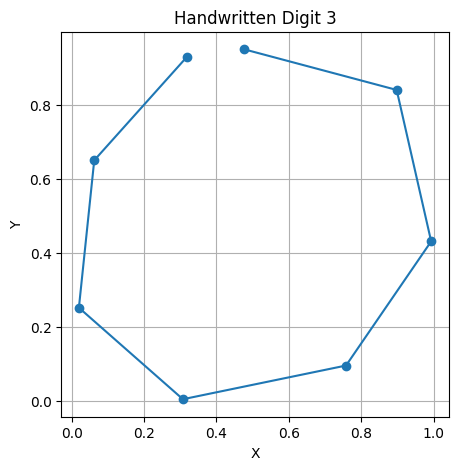

y = [1. 0.]


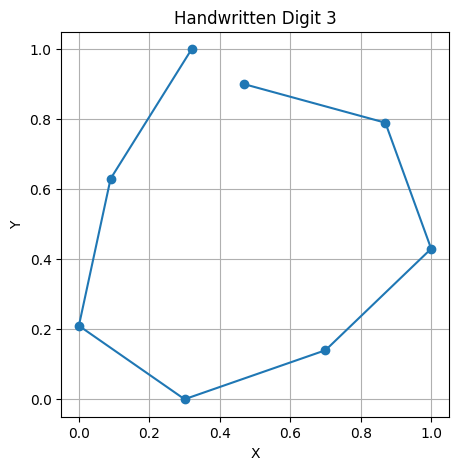

In [17]:
idx = 0
sample = X_test[idx:idx+1]
sample_label = y_test[idx:idx+1]
autoencoded_sample = autoencoder.predict(sample)
visualise_decoded_digit(autoencoded_sample,sample_label)
visualise_digit(X_test,y_test,idx)

In [18]:
#Gettting the Global weights, needed for counterfactuals

from _guided import get_global_weights
from help_functions import evaluate
pos_label = 1
neg_label = 0

step_weights = get_global_weights(
        X,
        y_classes,
        classifier,
        n_timesteps= n_timesteps,
        n_features=n_features,
        random_state=RANDOM_STATE,
)


72/72 [==============================] - 0s 5ms/step


In [19]:
step_weights

array([[[1., 1.],
        [1., 1.],
        [0., 1.],
        [1., 1.],
        [0., 1.],
        [0., 0.],
        [1., 1.],
        [1., 1.]]])

In [ ]:
reset_seeds()
cf_model = ModifiedLatentCF(
    probability=0.9,tolerance=1e-6, max_iter=500, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),autoencoder = autoencoder,
    pred_margin_weight=0.7, step_weights = step_weights, random_state= RANDOM_STATE)
cf_model.fit(classifier)

y_neg = y_classes[y_classes == 0]
X_neg = X[y_classes == 0]


with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning) # ignore warning of matrix multiplication: https://stackoverflow.com/questions/29688168/mean-nanmean-and-warning-mean-of-empty-slice
    cf_embeddings, losses, weights = cf_model.transform(X_neg, y_neg) #self, x, pred_label
cf_pred_labels = classifier.predict(cf_embeddings)[:,1]# predicted probabilities of CFs
for idx in range(cf_pred_labels.shape[0]):
  if cf_pred_labels[idx] > 0.5:
    cf_pred_labels[idx] = 1
  else:
    cf_pred_labels[idx] = 0

print(f'Transformation_finished with validity_score = {validity_score(y_neg,cf_pred_labels)}')

1 samples been transformed.


In [ ]:
for i in range(5):
   i=i+30
   print("actual")
   visualise_digit(X_neg,y_neg,i,figsize = (5,5))
   print("counterfactual")
   visualise_digit(cf_embeddings,y_neg,i,figsize = (5,5))


In [ ]:
#Calculating proximity withour absolute
from tensorflow.keras.losses import MeanSquaredError
total_mse = 0
probability = 0.9
for idx in range(cf_embeddings.shape[0]):
    counterfactual = cf_embeddings[idx,np.newaxis]
    prediction = classifier.predict(counterfactual)[:, 1]
    mse = MeanSquaredError()
    mse_dist = mse(probability, prediction).numpy()
    total_mse +=mse_dist
mean_mse = total_mse /cf_embeddings.shape[0]


In [ ]:
print(f"The Mean MSE of the data is: {mean_mse} ")

In [ ]:
#Calculating proximity with absolute
from tensorflow.keras.losses import MeanSquaredError
total = 0
probability = 0.9
for idx in range(cf_embeddings.shape[0]):
    counterfactual = cf_embeddings[idx,np.newaxis]
    prediction = classifier.predict(counterfactual)[:, 1]
    dist = abs(prediction - probability)
    total +=dist
mean_mse = total /cf_embeddings.shape[0]


In [ ]:
print(f"The Mean MSE of the data is: {mean_mse} ")

In [ ]:
#Proximity
def euclidean_distance(X, cf_samples):
    paired_distances = np.linalg.norm(X - cf_samples, axis=1)
    return np.mean(paired_distances)
euclidean_distance(X_neg, cf_embeddings)

In [ ]:
from scipy.stats import gaussian_kde

diffrences_from_abnormal = []
diffrences_from_normal = []
for dimention in range(cf_embeddings.shape[2]):


  abnormal_data = X[y_classes == 1][:,:,dimention]
  normal_data = X[y_classes == 0][:,:,dimention]
  counterf_data = cf_embeddings[:,:,dimention]

  #get the kernel for every dimention of the trained
  kernel = gaussian_kde(abnormal_data.T,bw_method=None)

  #get all the log likelihoods
  log_likelihood_abnormal = np.mean(kernel.logpdf(abnormal_data.T))
  log_likelihood_normal = np.mean(kernel.logpdf(normal_data.T))
  log_likelihood_counterfactual = np.mean(kernel.logpdf(counterf_data.T))

  #get the diffrences from the counterfactuals
  diff_from_abnormal = abs(log_likelihood_counterfactual-log_likelihood_abnormal)
  diffrences_from_abnormal.append(diff_from_abnormal)

  diff_from_normal = abs(log_likelihood_counterfactual-log_likelihood_normal)
  diffrences_from_normal.append(diff_from_normal)


In [ ]:
diffrences_from_normal

In [ ]:
diffrences_from_abnormal